# Clasificación de Imágenes de Caballos y Humanos utilizando LeNet-5

En este notebook, abordaremos el problema de clasificación binaria de imágenes de caballos y seres humanos utilizando una Red Neuronal Convolucional (CNN) basada en la arquitectura LeNet-5. El objetivo es construir un modelo capaz de distinguir entre imágenes de caballos y humanos con alta precisión.

Utilizaremos el dataset disponible en Kaggle que ya viene separado en carpetas de entrenamiento (`train`) y validación (`validation`). Emplearemos la carpeta `train` para entrenar y validar el modelo, y la carpeta `validation` para evaluar su rendimiento final.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


## Análisis Exploratorio de Datos (EDA)

Antes de entrenar el modelo, realizaremos un análisis exploratorio de datos para entender mejor el dataset.

In [2]:
# Definir rutas de las carpetas de datos
train_dir = 'datasets/horse-or-human/train'
validate_dir = 'datasets/horse-or-human/validation'

# Verificar las clases en el directorio de entrenamiento
classes = os.listdir(train_dir)
print("Clases encontradas en el conjunto de entrenamiento:", classes)

Clases encontradas en el conjunto de entrenamiento: ['horses', 'humans']


Número de imágenes por clase en entrenamiento:
horses: 500
humans: 527


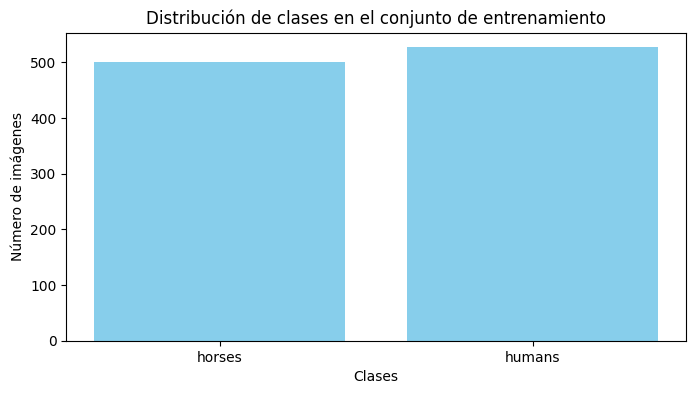

In [3]:
# Contar el número de imágenes por clase en el conjunto de entrenamiento
train_counts = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        train_counts[class_name] = len(os.listdir(class_path))

print("Número de imágenes por clase en entrenamiento:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

# Graficar la distribución de clases
plt.figure(figsize=(8, 4))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.show()


Número de imágenes por clase en validación:
horses: 128
humans: 128


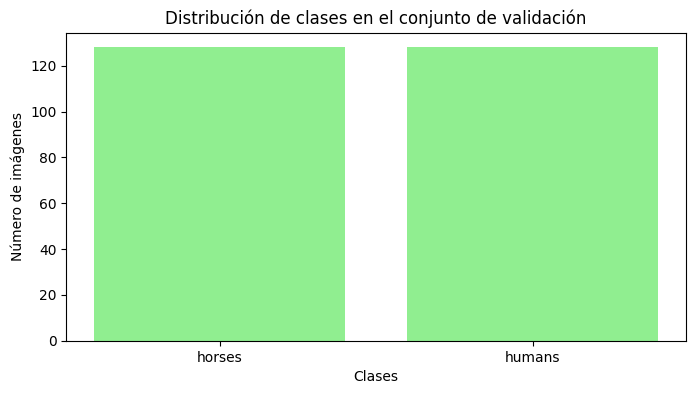

In [4]:
# Repetir para el conjunto de validación
validate_classes = os.listdir(validate_dir)
validate_counts = {}
for class_name in validate_classes:
    class_path = os.path.join(validate_dir, class_name)
    if os.path.isdir(class_path):
        validate_counts[class_name] = len(os.listdir(class_path))

print("\nNúmero de imágenes por clase en validación:")
for class_name, count in validate_counts.items():
    print(f"{class_name}: {count}")

# Graficar la distribución de clases
plt.figure(figsize=(8, 4))
plt.bar(validate_counts.keys(), validate_counts.values(), color='lightgreen')
plt.title('Distribución de clases en el conjunto de validación')
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.show()

## Carga y preprocesamiento de los datos

Utilizaremos `ImageDataGenerator` para cargar y preprocesar las imágenes. Aplicaremos un rescalado de las imágenes para normalizar los valores de los píxeles entre 0 y 1. Además, especificaremos las clases a utilizar para evitar problemas con archivos ocultos o directorios no deseados.

In [5]:
# Generadores de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training',
    classes=['horses', 'humans']
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    classes=['horses', 'humans']
)

# Generador de datos para evaluación
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    validate_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    classes=['horses', 'humans'],
    shuffle=False
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [6]:
# Verificar las clases
print("Clases en el generador de entrenamiento:", train_generator.class_indices)
print("Clases en el generador de validación:", validation_generator.class_indices)
print("Clases en el generador de prueba:", test_generator.class_indices)

Clases en el generador de entrenamiento: {'horses': 0, 'humans': 1}
Clases en el generador de validación: {'horses': 0, 'humans': 1}
Clases en el generador de prueba: {'horses': 0, 'humans': 1}


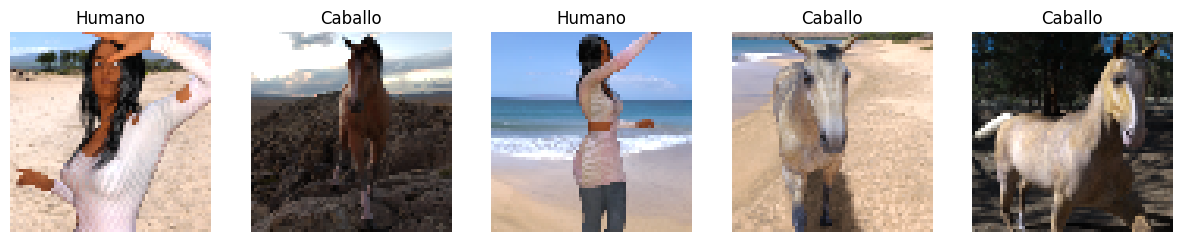

In [7]:
# Obtener una muestra de imágenes y etiquetas
sample_images, sample_labels = next(train_generator)

# Mostrar las primeras 5 imágenes del lote
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_images[i])
    label = 'Caballo' if sample_labels[i] == 0 else 'Humano'
    axes[i].set_title(label)
    axes[i].axis('off')
plt.show()

## Construcción del modelo basado en LeNet-5

Actualizaremos las funciones de activación a 'relu', que es más común en arquitecturas modernas y puede ayudar al rendimiento. También aumentaremos el tamaño de entrada de las imágenes para capturar más características.

In [8]:
model = models.Sequential()

# Primera capa convolucional y de pooling
model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(64, 64, 3), padding='same'))
model.add(layers.AveragePooling2D())

# Segunda capa convolucional y de pooling
model.add(layers.Conv2D(16, (5, 5), activation='relu'))
model.add(layers.AveragePooling2D())

# Tercera capa convolucional
model.add(layers.Conv2D(120, (5, 5), activation='relu'))

# Aplanamiento de la salida
model.add(layers.Flatten())

# Capas completamente conectadas
model.add(layers.Dense(84, activation='relu'))

# Capa de salida
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 6)         456       
                                                                 
 average_pooling2d (Average  (None, 32, 32, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 14, 14, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 12000)             0

## Compilación del modelo

Compilamos el modelo utilizando la función de pérdida `binary_crossentropy` adecuada para problemas de clasificación binaria. Como optimizador, emplearemos Adam y evaluaremos el rendimiento con la métrica de precisión.

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Entrenamiento del modelo

Entrenamos el modelo utilizando los generadores de datos de entrenamiento y validación. Ajustaremos el número de épocas según sea necesario para lograr una buena convergencia.

In [11]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
26/26 [==============================] - 6s 189ms/step - loss: 0.4448 - accuracy: 0.7908 - val_loss: 0.2762 - val_accuracy: 0.8683
Epoch 2/20
26/26 [==============================] - 5s 173ms/step - loss: 0.2014 - accuracy: 0.9100 - val_loss: 0.3064 - val_accuracy: 0.8927
Epoch 3/20
26/26 [==============================] - 4s 173ms/step - loss: 0.1285 - accuracy: 0.9465 - val_loss: 0.1372 - val_accuracy: 0.9463
Epoch 4/20
26/26 [==============================] - 5s 185ms/step - loss: 0.0969 - accuracy: 0.9684 - val_loss: 0.1767 - val_accuracy: 0.9415
Epoch 5/20
26/26 [==============================] - 4s 171ms/step - loss: 0.0392 - accuracy: 0.9866 - val_loss: 0.3202 - val_accuracy: 0.8829
Epoch 6/20
26/26 [==============================] - 5s 180ms/step - loss: 0.0171 - accuracy: 0.9964 - val_loss: 0.2340 - val_accuracy: 0.8927
Epoch 7/20
26/26 [==============================] - 4s 168ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.1674 - val_accuracy: 0.9171
Epoch 

## Evaluación del modelo

Evaluamos el rendimiento del modelo entrenado utilizando el conjunto de datos de validación y generamos la matriz de confusión y el informe de clasificación.

In [12]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Precisión en el conjunto de prueba: {test_accuracy*100:.2f}%')

8/8 [==============================] - 1s 63ms/step - loss: 1.5418 - accuracy: 0.8633
Precisión en el conjunto de prueba: 86.33%


9/9 [==============================] - 1s 55ms/step


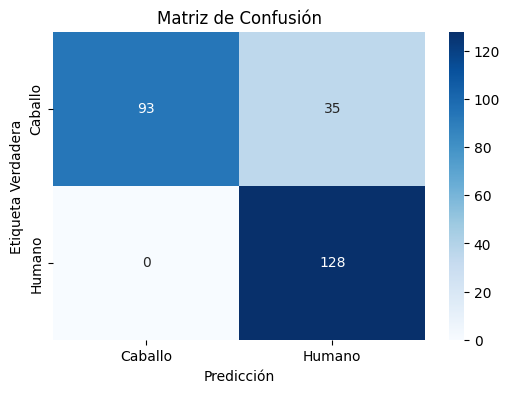

              precision    recall  f1-score   support

     Caballo       1.00      0.73      0.84       128
      Humano       0.79      1.00      0.88       128

    accuracy                           0.86       256
   macro avg       0.89      0.86      0.86       256
weighted avg       0.89      0.86      0.86       256



In [13]:
# Obtener predicciones
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = (Y_pred > 0.5).astype(int).flatten()

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Generar matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Caballo', 'Humano'], yticklabels=['Caballo', 'Humano'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
print(classification_report(y_true, y_pred, target_names=['Caballo', 'Humano']))

## Curvas de entrenamiento

Visualizamos las curvas de precisión y pérdida para analizar el rendimiento durante el entrenamiento.

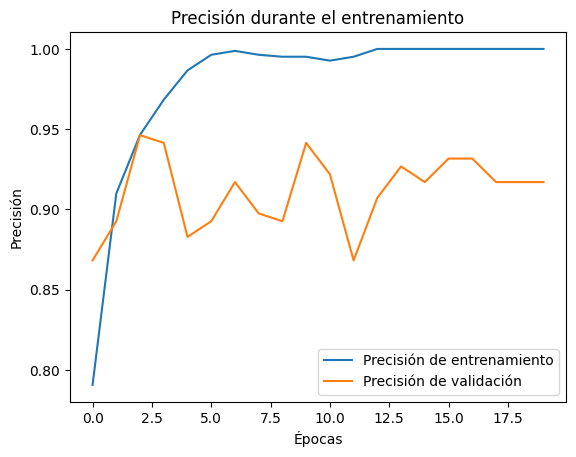

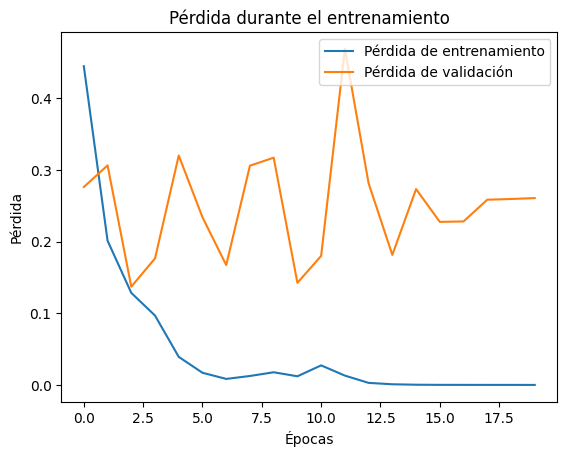

In [14]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
9406464/9406464 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 


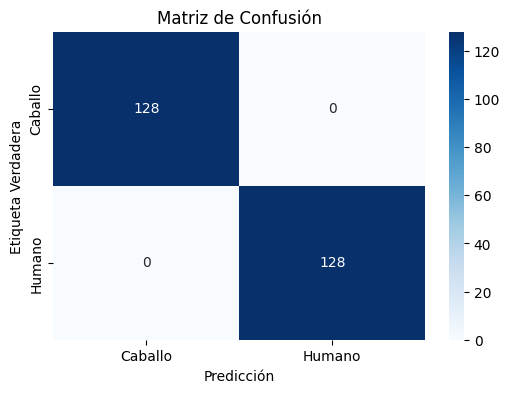

              precision    recall  f1-score   support

     Caballo       1.00      1.00      1.00       128
      Humano       1.00      1.00      1.00       128

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



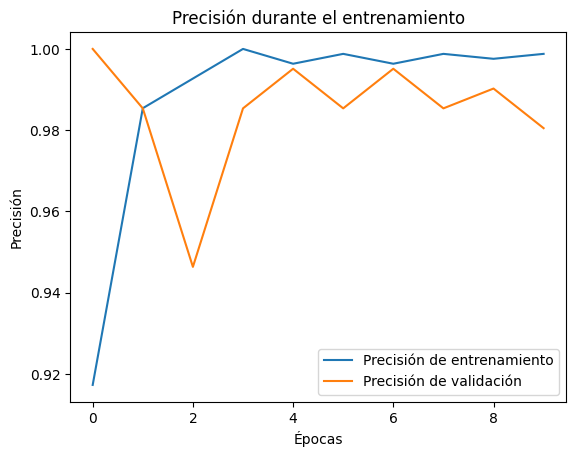

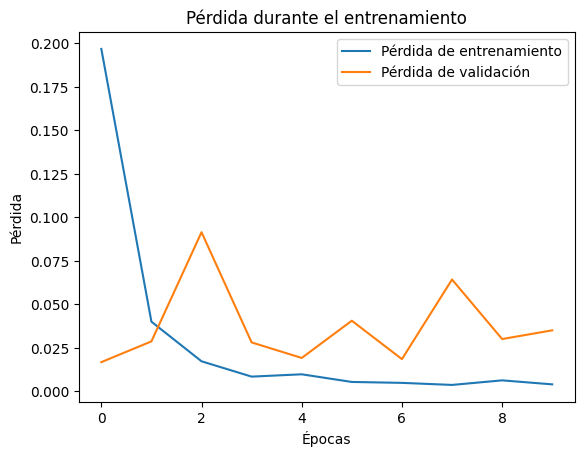

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Definir rutas de las carpetas de datos
train_dir = 'datasets/horse-or-human/train'
validate_dir = 'datasets/horse-or-human/validation'

# Generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    classes=['horses', 'humans']
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    classes=['horses', 'humans']
)

# Generador de datos para evaluación
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=['horses', 'humans'],
    shuffle=False
)

# Cargar el modelo base de MobileNetV2 sin las capas superiores y con pesos pre-entrenados
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Precisión en el conjunto de prueba: {test_accuracy*100:.2f}%')

# Obtener predicciones
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = (Y_pred > 0.5).astype(int).flatten()

# Obtener etiquetas verdaderas
y_true = test_generator.classes

# Generar matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Caballo', 'Humano'], yticklabels=['Caballo', 'Humano'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Informe de clasificación
print(classification_report(y_true, y_pred, target_names=['Caballo', 'Humano']))

# Curvas de entrenamiento
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


## Interpretación de los resultados


### Modelo 1: LeNet-5

- Precisión en el conjunto de entrenamiento y validación: El modelo alcanzó una precisión del 100% en el conjunto de entrenamiento, lo que indica un posible sobreajuste, ya que en el conjunto de validación la precisión máxima fue del 92%.
- Evaluación en el conjunto de prueba: El modelo tuvo una precisión de 86.33% en el conjunto de prueba. La matriz de confusión muestra que el modelo tiene un rendimiento más débil al identificar correctamente las imágenes de caballos, con una menor sensibilidad (recall).
- Problemas Observados: La diferencia significativa entre la precisión en el entrenamiento y la validación muestra que el modelo no generaliza bien a datos no vistos. Esto se debe a la complejidad de la arquitectura y al tamaño relativamente pequeño del dataset, lo que favorece el sobreajuste.

### Modelo 2: MobileNetV2 con Transfer Learning

- Precisión en el conjunto de entrenamiento y validación: El modelo alcanzó una precisión cercana al 100% tanto en el entrenamiento como en la validación en menos épocas. Esto refleja un ajuste mucho más eficiente y rápido gracias a la utilización de pesos pre-entrenados.
- Evaluación en el conjunto de prueba: El modelo obtuvo una precisión perfecta del 100% en el conjunto de prueba, lo que demuestra una excelente capacidad de generalización y precisión en la clasificación.
- Ventajas del Modelo: MobileNetV2 mostró una superioridad clara en la clasificación debido al uso de transferencia de aprendizaje, reduciendo la cantidad de entrenamiento necesario y aprovechando características ya aprendidas de grandes datasets. El uso de capas adicionales con regularización y aumento de datos también contribuyó a una mejor generalización.

## Comparativa de los Modelos:

### Precisión y Generalización:
- LeNet-5: Aunque alcanzó una buena precisión en el conjunto de entrenamiento, mostró una baja capacidad de generalización a nuevos datos debido al sobreajuste.
- MobileNetV2: Logró una precisión mucho mayor en el conjunto de prueba y mantuvo una excelente generalización, debido en gran parte al uso de transferencia de aprendizaje.

### Complejidad y Eficiencia:
- LeNet-5: Es un modelo más sencillo con una menor cantidad de parámetros, pero carece de la capacidad de aprendizaje que ofrecen modelos modernos con arquitecturas más profundas.
- MobileNetV2: A pesar de tener más parámetros, su estructura optimizada y el uso de pesos pre-entrenados lo hicieron más eficiente y poderoso en este caso de clasificación.

### Técnicas Adicionales:
- LeNet-5: No se utilizaron técnicas avanzadas como aumento de datos, lo que contribuyó al sobreajuste.
- MobileNetV2: Se aplicaron técnicas de regularización (Dropout) y aumento de datos, lo que mejoró el rendimiento general.

## Conclusiones

El modelo basado en MobileNetV2 superó claramente a la arquitectura de LeNet-5 en términos de precisión, generalización y eficiencia en el entrenamiento. Esto demuestra la eficacia de la transferencia de aprendizaje en tareas de clasificación con conjuntos de datos pequeños, mientras que modelos como LeNet-5, aunque históricos y fundamentales, son menos capaces de manejar las demandas y desafíos de tareas modernas de visión por computadora.
Dado que la precision del modelo fue de un 100%, harían más falta más datos o un menor numero de epocas para evitar el overfitting.